# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import os
import torch
from torchvision import datasets, transforms
from PIL import ImageFile
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

data_dir = '/data/landmark_images/train/'
test_dir = '/data/landmark_images/test/'

### Write data loaders for training, validation, and test sets
# Image transforms
transformations = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(size=(248)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

#dataset = '/data/landmark_images/train/'

train_data = datasets.ImageFolder(data_dir, transform=transformations['train'])
validation_data = datasets.ImageFolder(data_dir, transform=transformations['valid'])
test_data = datasets.ImageFolder(test_dir, transform=transformations['test'])

num_train = len(train_data)
indices = list(range(num_train))
valid_size = 0.2
split = int(np.floor(valid_size*num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

print(len(train_sampler))
print(len(valid_sampler))
print(len(test_data))
train_loader = torch.utils.data.DataLoader(train_data,
                                           sampler = train_sampler,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
valid_loader = torch.utils.data.DataLoader(validation_data,
                                           sampler = valid_sampler,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

3997
999
1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
1. I have choosen (224 224) as input size as I am going to use the same data loaders for transfer learning, As resnet accepts an input size of (224 224), I have used RandomResizedCrop to resize the image for train data. for test images I resized to 224.

2. Initially I have not augmented the dataset, so the test result accuracy was very low. later on I decided to augment and so I have horizantally flipped and rotated with an angle of 5. I have applied augmentation only for train data not for valid data. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

['20.Matterhorn',
 '21.Taj_Mahal',
 '22.Moscow_Raceway',
 '23.Externsteine',
 '24.Soreq_Cave']

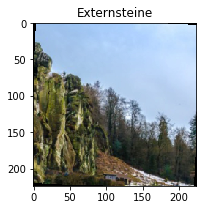

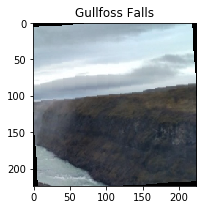

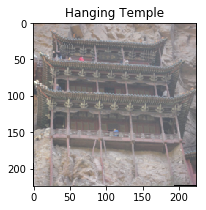

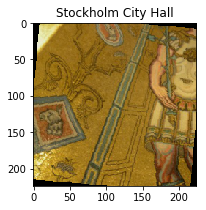

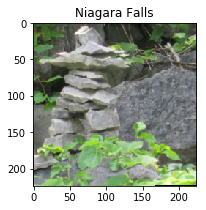

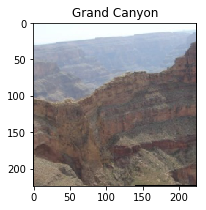

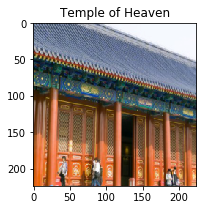

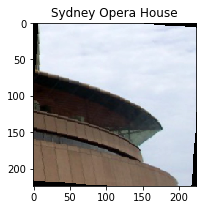

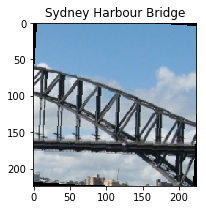

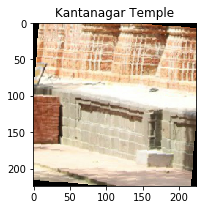

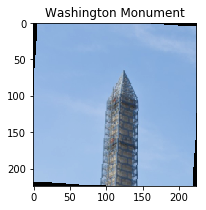

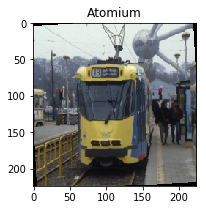

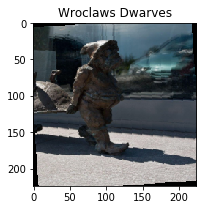

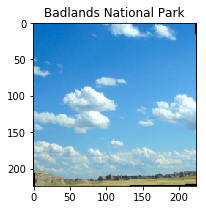

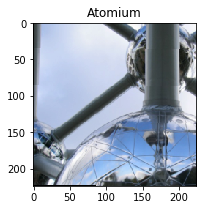

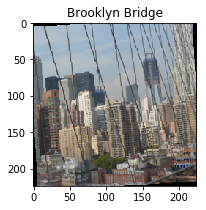

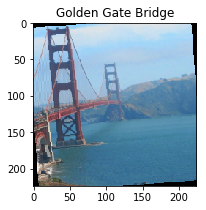

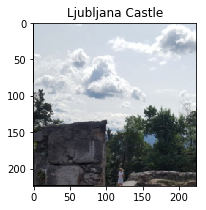

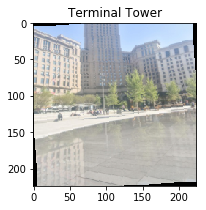

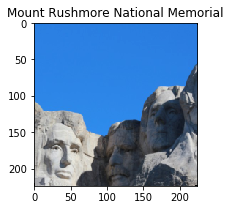

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

# Get a batch of training data
inputs, classes = next(iter(loaders_scratch['train']))

for image, label in zip(inputs, classes): 
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(12,3))
    plt.imshow(image)
    plt.title(class_names[label])

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

loaders_scratch['train'].dataset.classes[20:25]


### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
import torch.nn as nn
import torch.optim as optim
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.06)
    return optimizer_scratch
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch
import torch.nn.functional as F
num_classes = 50

use_cuda = torch.cuda.is_available()
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 512)
        self.fc2 = nn.Linear(512, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
        
        
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Prepare for linear layer
        x = x.view(-1, 7*7*128)
        
        # Classification
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#


# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=50, bias=True)
  (dropout): Dropout(p=0.3)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:

 I have designed complex architecture with very large mask and many FC layers after many trial and error architectures. My results were  poor for the test data. and also taking too much time even on GPU. So, I decided to make a simple architecture with simple masks like 3*3.

Steps. First, I have used conv layer with 3*3 kernel for extracting features input image size(224*224). I used stride of 2 as reducing the image size also important (112*112). Then I appled pooling layers then the resulting size was (56*56). then conv layers with stride followed by max pool layer (14*14) and then i have used convolutional layer followed by pooling layerand so my resulting size was 7*7 for classification I have used 2 FC layers, and a dropout layer with 30% droping.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))


            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
           # if batch_idx % 100 == 0:
            #    print('Epoch %d, Batch %d loss: %.6f' %
             #     (epoch, batch_idx + 1, train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 


            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.913664 	Validation Loss: 3.913102
Validation loss decreased (inf --> 3.913102).  Saving model ...
Epoch: 2 	Training Loss: 3.908807 	Validation Loss: 3.887241
Validation loss decreased (3.913102 --> 3.887241).  Saving model ...
Epoch: 3 	Training Loss: 3.842863 	Validation Loss: 3.822605
Validation loss decreased (3.887241 --> 3.822605).  Saving model ...
Epoch: 4 	Training Loss: 3.793508 	Validation Loss: 3.753739
Validation loss decreased (3.822605 --> 3.753739).  Saving model ...
Epoch: 5 	Training Loss: 3.764327 	Validation Loss: 3.690527
Validation loss decreased (3.753739 --> 3.690527).  Saving model ...
Epoch: 6 	Training Loss: 3.705904 	Validation Loss: 3.576238
Validation loss decreased (3.690527 --> 3.576238).  Saving model ...
Epoch: 7 	Training Loss: 3.642513 	Validation Loss: 3.568509
Validation loss decreased (3.576238 --> 3.568509).  Saving model ...
Epoch: 8 	Training Loss: 3.586984 	Validation Loss: 4.128948
Epoch: 9 	Training Loss: 3.572512 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.886431 	Validation Loss: 3.809972
Validation loss decreased (inf --> 3.809972).  Saving model ...
Epoch: 2 	Training Loss: 3.748204 	Validation Loss: 3.646298
Validation loss decreased (3.809972 --> 3.646298).  Saving model ...
Epoch: 3 	Training Loss: 3.644782 	Validation Loss: 3.571586
Validation loss decreased (3.646298 --> 3.571586).  Saving model ...
Epoch: 4 	Training Loss: 3.582557 	Validation Loss: 3.471471
Validation loss decreased (3.571586 --> 3.471471).  Saving model ...
Epoch: 5 	Training Loss: 3.494396 	Validation Loss: 3.323342
Validation loss decreased (3.471471 --> 3.323342).  Saving model ...
Epoch: 6 	Training Loss: 3.393122 	Validation Loss: 3.291898
Validation loss decreased (3.323342 --> 3.291898).  Saving model ...
Epoch: 7 	Training Loss: 3.360673 	Validation Loss: 3.373910
Epoch: 8 	Training Loss: 3.270061 	Validation Loss: 3.082910
Validation loss decreased (3.291898 --> 3.082910).  Saving model ...
Epoch: 9 	Training Loss: 3.190845 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.092890


Test Accuracy: 47% (592/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [7]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch.copy()
#loaders_transfer = {'train': None, 'valid': None, 'test': None}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [8]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.006)
    return optimizer_transfer
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [9]:
## TODO: Specify model architecture
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models

model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 50, bias=True)
fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
#optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.006)
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.006)
print(model_transfer)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 82366048.16it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I have choosen resnet50 model for the pretraining, as it gives better performance for classification. As resnet output layer has different classes I have modified to my requirement that is 50. I have frozen all conv layers and trained the network.


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [17]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

model_transfer =  train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1, Batch 1 loss: 3.991670
Epoch 1, Batch 101 loss: 3.791667
Epoch: 1 	Training Loss: 3.612239 	Validation Loss: 3.115482
Validation loss decreased (inf --> 3.115482).  Saving model ...
Epoch 2, Batch 1 loss: 3.158457
Epoch 2, Batch 101 loss: 3.106456
Epoch: 2 	Training Loss: 2.995272 	Validation Loss: 2.544636
Validation loss decreased (3.115482 --> 2.544636).  Saving model ...
Epoch 3, Batch 1 loss: 2.731110
Epoch 3, Batch 101 loss: 2.657614
Epoch: 3 	Training Loss: 2.567471 	Validation Loss: 2.155729
Validation loss decreased (2.544636 --> 2.155729).  Saving model ...
Epoch 4, Batch 1 loss: 1.951952
Epoch 4, Batch 101 loss: 2.318113
Epoch: 4 	Training Loss: 2.279207 	Validation Loss: 1.910007
Validation loss decreased (2.155729 --> 1.910007).  Saving model ...
Epoch 5, Batch 1 loss: 2.078564
Epoch 5, Batch 101 loss: 2.108213
Epoch: 5 	Training Loss: 2.091253 	Validation Loss: 1.776278
Validation loss decreased (1.910007 --> 1.776278).  Saving model ...
Epoch 6, Batch 1 loss: 1.

In [10]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [121]:
#for loading 
#torch.load('model_transfer.pt', map_location=lambda storage, loc: storage)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)       
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        output = F.softmax(output, dim=1)
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.299751


Test Accuracy: 70% (881/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [88]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

class_names = [item[3:].replace("_", " ") for item in train_data.classes]

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    # load the image and return the predicted landmarks
    img = Image.open(img_path)

    # Define normalization step for image
    normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))

    # Define transformations of image
    preprocess = transforms.Compose([transforms.Resize(258),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])

    # Preprocess image to 4D Tensor (.unsqueeze(0) adds a dimension)
    img_tensor = preprocess(img).unsqueeze_(0)

    # Move tensor to GPU if available
    if use_cuda:
        img_tensor = img_tensor.cuda()
        
    ## Inference
    # Turn on evaluation mode
    model_transfer.eval()
    
    # Get predicted category for image
    with torch.no_grad():
        output = model_transfer(img_tensor)
        #print(output[0:2])
        #prediction = torch.argmax(output).item()
        #prediction = torch.argmax(output)
        #print(prediction)
        prediction = torch.topk(output,k,dim=1,largest=True,sorted=True,out=None)[1]
        #print(k)
        #print(prediction)
        # Turn off evaluation mode
    model_transfer.train()
    
    # Use prediction to get dog breed
    landmark = []
    for n in range(k):
       i =prediction[0,n].item()
        
       j = class_names[i]
       landmark.append(j)
       #print(landmark)
    #print(landmark)
    return landmark   


# test on a sample image
predicted_landmarks = predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)
print(predicted_landmarks)

['Golden Gate Bridge', 'Forth Bridge', 'Sydney Harbour Bridge', 'Brooklyn Bridge', 'Dead Sea']


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [89]:
loaders_transfer['train'].dataset.classes[:10]

['00.Haleakala_National_Park',
 '01.Mount_Rainier_National_Park',
 '02.Ljubljana_Castle',
 '03.Dead_Sea',
 '04.Wroclaws_Dwarves',
 '05.London_Olympic_Stadium',
 '06.Niagara_Falls',
 '07.Stonehenge',
 '08.Grand_Canyon',
 '09.Golden_Gate_Bridge']

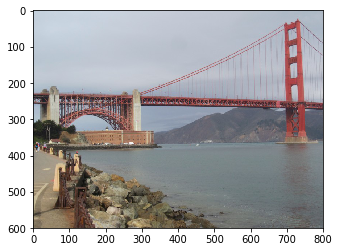

Is this the picture of  Golden Gate Bridge Forth Bridge Sydney Harbour Bridge ?


In [106]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print("Is this the picture of ", *predicted_landmarks,"?")
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
Yes the output is better than expected.

(Three possible points for improvement)

1. Hyper parameter tuning eg. playing with learning rate, batch size.
2. Increase in the number of epochs.
3. We may also increase the accuracy my increasing the size of dataset i.e, training data.




1


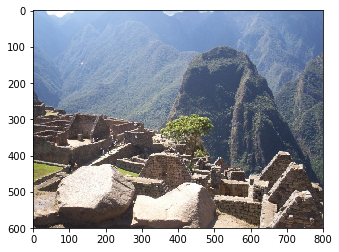

Is this the picture of  Machu Picchu Great Wall of China Hanging Temple ?


In [110]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
from glob import glob

test_images = np.array(glob("../landmark_project/images/test/41.Machu_Picchu/*"))
print(len(test_images))
for file in np.hstack((test_images[:])):
    suggest_locations(file)



10


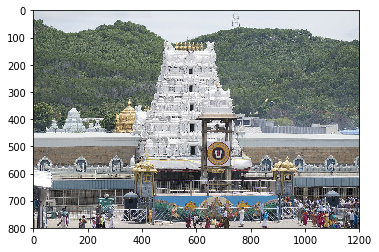

Is this the picture of  Hanging Temple Prague Astronomical Clock Temple of Heaven ?


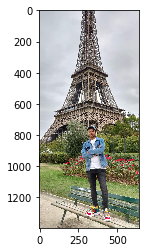

Is this the picture of  Eiffel Tower Seattle Japanese Garden Atomium ?


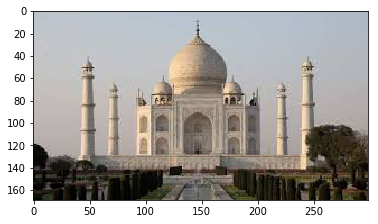

Is this the picture of  Gateway of India Monumento a la Revolucion Taj Mahal ?


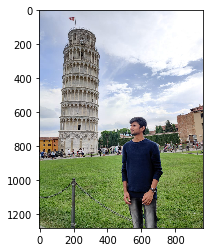

Is this the picture of  Whitby Abbey London Olympic Stadium Terminal Tower ?


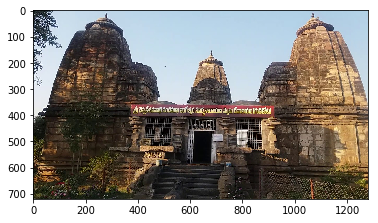

Is this the picture of  Hanging Temple Temple of Heaven Changdeokgung ?


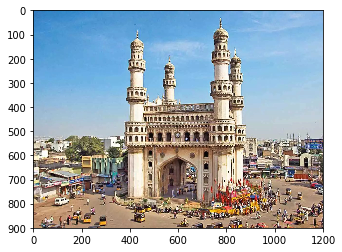

Is this the picture of  Terminal Tower Gateway of India Vienna City Hall ?


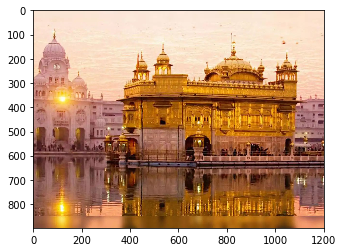

Is this the picture of  Vienna City Hall Gateway of India Kantanagar Temple ?


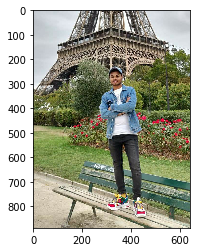

Is this the picture of  Eiffel Tower Seattle Japanese Garden Great Wall of China ?


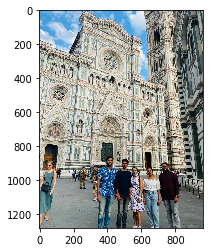

Is this the picture of  Vienna City Hall Gateway of India Terminal Tower ?


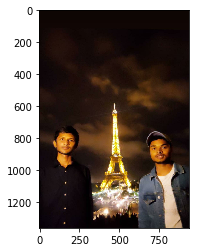

Is this the picture of  London Olympic Stadium Vienna City Hall Eiffel Tower ?


In [119]:
from glob import glob

test_images = np.array(glob("../landmark_project/images/mytest/*"))
print(len(test_images))
for file in np.hstack((test_images[:])):
    suggest_locations(file)